# The demographic future of Israel: Investigating possible scenarios with dynamic modelling

Israel is characterized by strong internal divisions between religious and ethnic groups, each striving to break the status quo and put forward a political agenda that would serve its interest. Although this scheme, one would argue, is natural to any population and inherent to any political activity, the common values shared by the main groups are so few that one could say with certainty that any change in the power balances will have tremendous eﬀects on the life of the people in the country, and perhaps even in the whole region. It is clear that the respective sizes of the diﬀerent groups will be the key variable in determining the future of the country. 

In this notebook, I investigate possible future development of the population of diﬀerent groups in the Israeli populations. The number of these groups is very large, but three are clearly distinguishable by their radically diﬀerent ways of life, ideology, and political agenda: the non-Orthodox Jews, the Orthodox Jews (also called Haredi, pl. Haredim), and the Muslims. The ﬁrst group, representing about 70 % of the population, is currently dominating the political life of the country, and, although it is divided about questions of foreign policy, it shares the consensus around the Jewish, secular and democratic character of the country. The second group, the Orthodox Jews, representing around 10% of the population, are mainly interested in imposing a more religious, very conservative way of life on the country. The third group, the Arab Mulsims (8%), although beneﬁting from equal rights as citizens, are mainly opposed to the Jewish character of the State and interested in an integration of the country into the political landscape of the Middle East.
These three groups are characterized by diﬀerent fertility trajectories and levels over the last decades. The fertility rates of the Arabs, while being traditionally very high, have been constantly decreasing in the last decades and are now converging towards those of the non-Orthodox Jews, which remained roughly constant over time. On the other hand, the Ultra-Orthodox Jews, originally of a negligible size, have been growing exponentially due to very high fertility rates. 

Based on statistics of the [Israeli Central Bureau of Statistics (CBS)](http://cbs.gov.il/en/) and a few working assumptions, I forecast the populations of these three groups for the upcoming 100 years. There exist several possible demographic trajectories for these groups. The interactive plotting tool in the end of this notebook allows the exploration of these trajectories under different scenarios.

**Importing libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Reading data in and transforming to yearly format**

*vital_stats.csv* are vital statistics and migration data that I prepared based on the statistics of the Israeli CBS. 

They are stored as a data frame with the following columns
1: age
2: Non-haredi Jewish male mortality
3: Non-haredi Jewish female mortality
4: Arab Muslim male mortality
5: Arab Muslim female mortalty
6: Haredi male mortality (assumed to be the same as their non-haredi Jewish pairs)
7: Haredi female mortality (assumed to be the same as their non-haredi Jewish pairs)
8: Non-haredi Jewish fertility
9: Muslim Arab fertility
10: Haredi fertility
11: Overall male emigration
12: Overall female emigration
13: Jewish male migration (Aliyah)
14: Jewish female migration (Aliyah)

In [7]:
vs = pd.read_csv("vital_stats.csv")
vs["span"] = np.append(np.array([1,4]), np.repeat(5,19))#number of years per age group
vs = vs.iloc[:,1:].reindex(vs.index.repeat(vs.span))#reindexing to yearly format
vs.reset_index(drop = True, inplace = True)
vs.iloc[:, -2:] = vs.iloc[:, -2:].div(vs.span, axis = 0)#dividing migration rate to match a single year
vs.drop("span", axis = 1, inplace = True)
vs.iloc[:,:-2] = vs.iloc[:,:-2]/1000#migration rate per thousand

## Mortality and fertility rates

Since the population clustered by truncated age on Jan 1, the mortality and fertility rates are for an age group is the average between the truncated age on Jan 1 x and x+1. 

In [8]:
mx = vs.loc[:,vs.columns.str.match("m_.*")].values#numpy array
mx_ = (mx[:-1,:] + mx[1:,:])/2#
mx_ = np.row_stack([mx[0,]/2, mx_])

fx = vs.loc[:,vs.columns.str.match("f_.*")].values
fx_ = np.row_stack([(fx[1:,:] + fx[:-1,:])/2,
                    fx[-1,:]])#averaging rates for age x and x+1

**Functions for 1-sex and 2-sex Leslie matrices**

A Leslie matrix $L^F$ for the female population contains the age-specific birth counts per woman during t and survivorships to the next age group, so that a dot multiplication of an age-specific female population vector at time t **$n^F_t$** by **$L^F$** yields the female population vector for next time unit t, **$n^F_{t+1}$**.

Here is an example of simple a Leslie matrix (for 4 age groups). $s^F_x$ are the age-specific survivorships for females and $b^F_x$ the daughters counts per woman.

$$
\begin{bmatrix}
N_0 (t+1)\\N_1 (t+1)\\N_2 (t+1) \\N_3 (t+1) 
\end{bmatrix}
=
\begin{bmatrix}
b^F_0 & b^F_1 & b^F_2 & b^F_3\\
s^F_0 & 0 & 0 & 0\\
0 & s^F_1 & 0 & 0\\
0 & 0 & s^F_2 & 0\\
\end{bmatrix}
\cdot
\begin{bmatrix}
N_0 (t)\\N_1 (t)\\N_2 (t) \\N_3 (t) 
\end{bmatrix}
$$

If we want to integrate males into this equation, we stack the vectors for female and male populations, we remove $b_x$ from the male Leslie matrix $L^M$, as they don't give birth, but create a separate matrix **$B^M$**, which generates birth by multiplication with the female population: 

$$
\begin{bmatrix}
\mathbf{N^F}(t+1) \\ \mathbf {N^M} (t+1)
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{L^F} & 0 \\
\mathbf{B^M} & \mathbf{L^M}
\end{bmatrix}
\cdot
\begin{bmatrix}
\mathbf{N^F}(t) \\ \mathbf {N^M} (t)
\end{bmatrix}
$$

Where
$$
\mathbf{B^M} = 
\begin{bmatrix}
b^M_0 & b^M_1 & b^M_2 & b^M_3\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
\end{bmatrix}
$$, 
$$
\mathbf{L^M} = 
\begin{bmatrix}
0 & 0 & 0 & 0\\
s^M_0 & 0 & 0 & 0\\
0 & s^M_1 & 0 & 0\\
0 & 0 & s^M_2 & 0\\
\end{bmatrix}
$$

In [9]:
def Leslie(mx, fx = None):
    sx = 1-mx/(1+0.5*mx)#from rate to death probability
    L = np.zeros((100, 100))
    np.fill_diagonal(L[1:,:-1], sx[1:])
    if fx is not None:
        bx = sx[0]*(fx*(1-(1-sx)/2))#new births times survival of first year times women's average survival
        bx = bx*(1/2.05)#male ratio
        L[0,:] = bx
    return L
def Leslie_2S(mx_f, mx_m, fx):
    top_left = Leslie(mx_f, fx)
    bottom_right = Leslie(mx_m)
    bottom_left = np.zeros((100,100))
    sx_f = 1-mx_f/(1+0.5*mx_f)
    newborn_s = 1-mx_m[0]/(1+0.5*mx_m[0])
    bottom_left[0,:] = newborn_s*(1.05/2.05)*(fx*(1-(1-sx_f)/2))
    L = np.zeros((200,200))
    L[:100,:100] = top_left
    L[100:,:100] = bottom_left
    L[100:, 100:] = bottom_right
    return L  

**Reading population structure at time 0 (2016 - 2018)**

In [10]:
n0 = pd.read_csv("n0.csv")
n0 = n0.iloc[:,1:].interpolate()#interpolation for last age groups 
n0 = n0.values
n0[-2:, :] = n0[-2:, :]/np.array([2,4])[:,None] #interpolating to zero for last rows

The Haredi population is estimated to be around 1M individuals as of the end of the 2010's. However, we don't have data for the poplation structure of the Haredim. To approximate it, we derive the stable age structure from their Leslie matrix. This can be done by taking the dominant eigen vector of them matrix. 

In [11]:
L_h = Leslie_2S(mx_[:,5], mx_[:,4], fx_[:,2])#2-sex Leslie matrix
eigvals, eigvecs = np.linalg.eig(L_h)#working out eigenvalues and vectors
pyramids = np.abs(eigvecs[:,np.argmax(eigvals)])#dominant eigenvector
age_struct_fh = pyramids[:100]/pyramids[:100].sum()#standardizing
age_struct_mh = pyramids[100:]/pyramids[100:].sum()
#we multiply 1M by the estimated share for each age, adjusted by the estimated living male-female ratio
n0 = np.column_stack([n0, age_struct_mh*1000*(1.03/2.03), age_struct_fh*1000*(1/2.03)])
n0[:,0] -= n0[:,-1]#extracting Haredi population from overall Jewish population
n0[:,1] -= n0[:,-2]

**Migration**

Outmigration is estimated by taking the number of Israelis leaving the countries minus those who return. The age-specific distribution by religion is unknown, but we know that Jews are about 1.4 more likely to leave. Therefore we approximate the  religion- and population-specific outmigration rates based on population structures and by multiplying by the all-age religion-specific likelihood to emigrate.

In-migration is almost exclusively Jewish ("Alyiah"). The age-specific distribution is given. We assume that it distributes 90% - 10% between non-haredim and haredim. 

In [12]:
n0_m = n0[:, [0,2,4]]#male population
n0_f = n0[:, [1,3,5]]#female population
props_m = n0_m/n0_m.sum()#proporions
props_f = n0_f/n0_f.sum()
props_m *= np.array([1.4, 1, 1.4])#multiplying by religion specific factor
props_f *= np.array([1.4, 1, 1.4])
props_m /= props_m.sum(axis = 1)[:,None]#standardizing
props_f /= props_f.sum(axis = 1)[:,None]

ex = vs.loc[:,vs.columns.str.match("out_")].values#outmigration rates
ex_f = props_f*ex[:,1][:,None]#religion and age specific rates for females
ex_m = props_m*ex[:,0][:,None]#and males
ex = np.zeros((100,6))
ex[:,[0,2,4]] = ex_m
ex[:,[1,3,5]] = ex_f
ex_ = np.row_stack([ex[0,:]/2,
                   (ex[1:,:]+ex[:-1,:])/2])


**Population-specific projections**

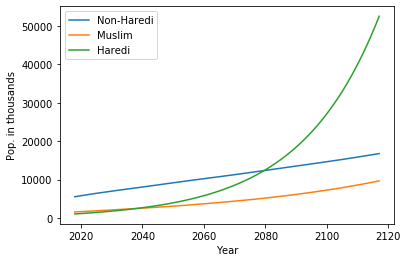

In [20]:
#population vectors
N_h = np.zeros((200, 100))#haredi
N_nh = np.zeros((200, 100))#non-haredi jews
N_a = np.zeros((200, 100))#muslim arabs
#Leslie matrices for each group
L_h = Leslie_2S(mx_[:,5]+ex_[:,5],
                mx_[:,4]+ex_[:,4],
               fx_[:,2])
L_a = Leslie_2S(mx_[:,3]+ex_[:,3],
                mx_[:,2]+ex_[:,2],
               fx_[:,1])
L_nh = Leslie_2S(mx_[:,1]+ex_[:,1],
                mx_[:,0]+ex_[:,0],
               fx_[:,0])
#stacking both sexes 
Nt_h = np.concatenate([n0[:,5], n0[:,4]])
Nt_nh = np.concatenate([n0[:,1], n0[:,0]])
Nt_a = np.concatenate([n0[:,3], n0[:,2]])

in_migr = np.concatenate([vs.iloc[:,-1], vs.iloc[:,-2]])#stacking immigration for both sexes
#matrix product of Leslie matrix and population vector at t + immigration 
for i in range(100):
    N_h[:,i] = L_h@Nt_h + 0.1*in_migr
    N_nh[:,i] = L_nh@Nt_nh + 0.9*in_migr
    N_a[:,i] = L_a@Nt_a
    
    Nt_h = N_h[:,i]
    Nt_nh = N_nh[:,i]
    Nt_a = N_a[:,i]
S = np.column_stack([N_nh.sum(axis = 0),
                     N_a.sum(axis = 0), 
                     N_h.sum(axis = 0)])
plt.plot(range(2018, 2118), N_nh.sum(axis = 0), label = "Non-Haredi")
plt.plot(range(2018, 2118), N_a.sum(axis = 0), label = "Muslim")
plt.plot(range(2018, 2118), N_h.sum(axis = 0), label = "Haredi")
plt.xlabel("Year")
plt.ylabel("Pop. in thousands")
plt.legend()

Under an assumption of constant fertility and mortality, the Ultra Orthodox population (Haredim) grows exponentially and becomes the largest group within 50-60 years.


**Adding defection rates**

According to recent estimates, about 9% of Haredi-born will become non-haredi over their life course. This occurs mainly during young adulthood (18-late 20's). We model the age distribution with the gamma distribution. To integrate defection into the model, we create a single Leslie matrix for all populations:

$$
\begin{bmatrix}
N^{NHJ} (t)\\N^{Mus} (t)\\N^{Har} (t)\\ 
\end{bmatrix}
 = 
\begin{bmatrix}
L^{NHJ} & 0 & D^{H-> NHJ}\\
0 & L^{Mus} & 0\\
0 & 0 & L^{Har}
\end{bmatrix}
\cdot
\begin{bmatrix}
N^{NHJ} (t+1)\\N^{Mus} (t+1)\\N^{Har} (t+1)\\ 
\end{bmatrix}
$$

Where $D^{H-> NHJ}$ is the defection matrix from Haredi to non-haredi, i.e. a zero-matrix whose diagonal is filled with defection probabilities. 

In [21]:
from scipy.stats import gamma
def defection_rate(survival_prob):
    """
    survival_prob: probability to survive (i.e. not to pass to another population)
    return the defection rates as modelled with a gamma distributi given the survival probability. 
    """
    #defection rate distribution bu age
    dx = np.diff(gamma.cdf(np.arange(0,100,1), a = 2, scale = 1.5, loc = 18))*(-np.log(survival_prob)) 
    dx = np.append(dx, 0)
    dx_ = (dx[:-1]+dx[1:])/2#averaging age rates of age x and x+1
    dx_ = np.append(dx_, 0)
    return dx
def Leslie_all(mx_, ex_, dx_, fx_):
    L = np.zeros((600,600))
    #adding rates of disappearing from haredi population (death, emigration and defection)
    rates_hf = mx_[:,5] + ex_[:,5] + dx_
    rates_hm = mx_[:,4] + ex_[:,4] + dx_
    #Leslie for non Haredim
    L[:200, :200] = Leslie_2S(mx_[:,1] + ex_[:,1],
                              mx_[:,0] + ex_[:,0],
                              fx_[:,0])
    #Leslie for Muslim Arabs
    L[200:400, 200:400] = Leslie_2S(mx_[:,3] + ex_[:,2],
                              mx_[:,2] + ex_[:, 2],
                              fx_[:,1])
    #Leslie for Haredim
    L[400:600, 400:600] = Leslie_2S(rates_hf,
                              rates_hm,
                              fx_[:,2])
    probs_hm = rates_hm/(1+0.5*rates_hm)#probability to disappear from Haredi population
    probs_hf = rates_hf/(1+0.5*rates_hf)#
    probs = np.concatenate([probs_hf, probs_hf])
    #adding haredi defectors to non haredim, adjusted for probabilities not to survive in the Haredi population
    np.fill_diagonal(L[1:200, 400:-1], (np.concatenate([dx_, dx_])*0.5*(1+probs))[:-1])
    return L

**Modelling with defection**

We integrate defection into the model with the Leslie matrix defined above (*Leslie_all(...)*). We can see that the stable, long term growth rate, as given by the dominant eigenvalue of the Leslie matrix for all populations, is driven by the Haredi growth rate, despite defection rates of ~10%. However, it takes about 300 years untill we reach this rate.

Text(2170, 0.028, 'share of haredim increases')

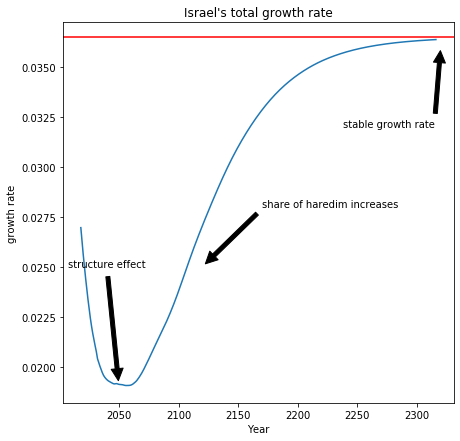

In [16]:
dx_ = defection_rate(0.9)#defection rates for a life-long probability of 90% to stay in the Haredi world
#population vector
N0 = np.zeros((600,))
N0[:200] = np.concatenate([n0[:,1], n0[:,0]])
N0[200:400] = np.concatenate([n0[:,3], n0[:,2]])
N0[400:600] = np.concatenate([n0[:,5], n0[:,4]])

L = Leslie_all(mx_, ex_, dx_, fx_)
N = np.zeros((600,300))
Nt = N0
for i in range(300):
  Nt = L@Nt  
  Nt += np.concatenate([in_migr*0.9, in_migr*0, in_migr*0.1])
  N[:,i] = Nt
n = N.sum(axis = 0)
fig, ax = plt.subplots(figsize = (7,7))
ax.set_title("Israel's total growth rate")
ax.set_xlabel("Year")
ax.set_ylabel("growth rate")
ax.plot(range(2018, 2317), -1 + n[1:]/n[:-1])
ax.axhline(y = -1 + np.abs(np.linalg.eig(L)[0]).max(), color = "red")
ax.annotate('stable growth rate', xy=(2320, 0.036),  xycoords='data',
            xytext=(2238, 0.032),
            arrowprops=dict(facecolor='black', shrink = 0.05),
            horizontalalignment='left')
ax.annotate('structure effect', xy=(2050, 0.019),  xycoords='data',
            xytext=(2040, 0.025),
            arrowprops=dict(facecolor='black', shrink = 0.05),
            horizontalalignment='center')
ax.annotate('share of haredim increases', xy=(2120, 0.025),  xycoords='data',
            xytext=(2170, 0.028),
            arrowprops=dict(facecolor='black', shrink = 0.05),
            horizontalalignment='left')

**Dynamic modelling**

So far, we assumed that mortality, fertility, migration and defection rates are stable over time. This is unlikely to happen. Here, we define a few functions that accommodate possible changes. 

First, **we have observed a decline in fertility in many societies**, including the Muslim world. The Muslim socieity in Israel is undoubtedly undergoing such changes, and clearly converges towards a two-child family norm. Whether this is will be the case is unclear. **No significant trend of decreasing fertility could be observed for Haredi women**, and [total fertility fluctuated around 7 children per woman since around 1990](https://www.cbs.gov.il/en/publications/Pages/pw/Fertility-among-Jewish-Women-in-Israel-by-Level-of-Religiosity-1979-2014.aspx). 

Second, **fertility can be driven endogenously by the share of a group in the population**. For instance, we can imagine that as the share of Haredim in the total population will grow, the capacity of the society to sustain such a grwoth economically will be impaired. Consequently, the Haredi population will gradually converge towards a lower birth rate. 

Third, **outmigration can be determined endogenously**. We can imagine a scenario in which the economic and societal changes induced by the growing Haredi population multiplies the odds of leaving the country for other groups. 

These three scenarios are implemented in the projection functions of the population (*project()*). The functions *dyn_fert()* accommodates trends in fertility by returning the yearly fertility rates for a group given the year and the hypothetized trend. *end_migration()* and *end_fertility()* accommodates changes in emigration (for non-Haredim) and fertility (for Haredim) depending on the share of Haredim in the total population and according to a hypothetized trend. 

In [22]:
def dyn_fert(fx, year, target_fact, trans_time):
    """
    fx: initial age-specific fertility rates
    year: the year since onset of transition
    target_fact: a factor by which actual fx is multiplied when transition completes.
    trans_time: length of transition in years
    """
    d = (1-target_fact)/trans_time
    fact = 1-d*year if year <= trans_time else target_fact 
    return fact*fx

def end_migration(ex, p, max_fact, max_p):
    """
    ex: initial age-specific outmigration rates
    p: share of Haredim in the total population
    max_fact: a maximum factor by which actual ex is multiplied when the Haredim reaches a proportion max_p.
    trans
    max_p: maximum proportion beyond which the growth of Haredi population does not affect outmigration rates.
    """
    assert max_p > 0.12
    d = (max_fact - 1)/(max_p - 0.12)
    fact = min(1+d*(p-0.12), max_fact)
    return fact*ex
    
def end_fert(fx, p, target_fact, target_p):
    """
    fx: initial age-specific fertility rates
    p: share of Haredim in the total population
    max_fact: a maximum factor by which actual fx is multiplied when the Haredim reaches a proportion max_p.
    trans
    max_p: maximum proportion beyond which the growth of Haredi population does not affect fertility rates.
    """
    d = (1-target_fact)/(target_p - 0.12)
    fact = 1-d*(p-0.12)
    return fact*fx

def project(years, mx, ex, dx, fx, end_fert_model = False):
    """
    years: no. of years to project
    mx: matrix of age-specific mortality rates [Jewish male non-Haredim, Jewish female non-Haredim,
                                    male Muslims, female Mulsims,
                                    male Haredim, female Haredim]
    ex: matrix of age-specific emigration rates with the same format
    dx: defection rates for Hredim to non-Haredim
    fx: matrix of age-specific fertility rate [Jewish non-Haredim, Muslims, Haredim]
    end_fert_model: boolean, whether Haredi fertility is endogeneous and depends on their share in the population 
    """
    N = np.zeros((600,years))
    Nt = N0
    for i in range(years):
        sums = np.array([Nt[:200].sum(), Nt[200:400].sum(), Nt[400:].sum()])
        comp = sums/sums.sum()
        ex1 = ex.copy()
        fx1 = fx.copy()
        ex1[:,0:4] = np.apply_along_axis(end_migration, 0,  ex[:,0:4], comp[2], target_migr_fact, target_prop_migr)
        if end_fert_model:
            fx1[:,2] = end_fert(fx[:,2], comp[2], target_fert_fact_h, target_prop_fert)
            fx1[:,1] = dyn_fert(fx[:,1], i, target_fert_fact_a, trans_time_a)
        else:
            fx1[:,2] = dyn_fert(fx[:,2], i, target_fert_fact_h, trans_time_h)
            fx1[:,1] = dyn_fert(fx[:,1], i, target_fert_fact_a, trans_time_a)
        L = Leslie_all(mx, ex1, dx, fx1)
        Nt = L@Nt  
        Nt += np.concatenate([in_migr*0.9, in_migr*0, in_migr*0.1])
        N[:,i] = Nt
    n_nh = N[:200,:]
    n_a = N[200:400,:]
    n_h = N[400:,:]
    S = np.column_stack([n_nh.sum(axis = 0), n_a.sum(axis = 0), n_h.sum(axis = 0)])
    return N,S

**Example**

We show the projection of the population of our three groups of interest with the following assumptions:
 - Non-haredi migration is linearly converging towards twice the current rates (`target_migr_fact = 2`) as Haredi share in population progress towards 0.5 (`target_prop_migr = 0.5`)
 - Haredi fertility is linearly converging towards half the current value (`target_fert_fact_h = 0.5`) within 40 years (`trans_time_h = 40`)
 - Muslim Arab fertility is linearly converging towards 0.8 the current value (`target_fert_fact_a = 0.8`) within 20 years (`trans_time_a = 40`)
 - Haredi fertility is not endogenous, i.e. does not depend on their share in the population (`end_fert_model = False`)
 



Text(0.5, 1.0, 'Dependency ratio')

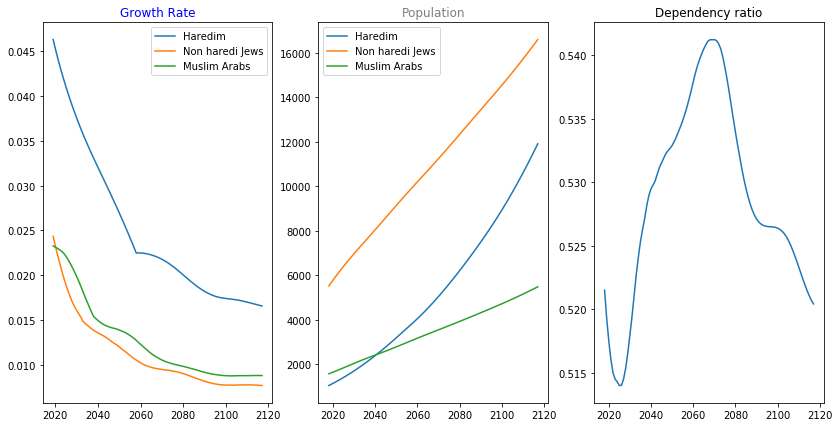

In [18]:
target_migr_fact = 2; target_prop_migr = 0.5
target_fert_fact_h = 0.5; trans_time_h = 40 
target_fert_fact_a = 0.8; trans_time_a = 20
#target_prop_fert = 0.4
dx_ = defection_rate(0.99)


N, S = project(100, mx_, ex_, dx_, fx_, end_fert_model = False)

fig, ax = plt.subplots(1,3, figsize = (14,7))
years = list(range(2018,2118))
ax[1].plot(years, S[:,2], label = "Haredim")
ax[1].plot(years, S[:,0], label = "Non haredi Jews")
ax[1].plot(years, S[:,1], label = "Muslim Arabs")
ax[1].legend()
ax[1].set_title("Population", color = "grey")

G = np.apply_along_axis(lambda x : x[1:]/x[:-1], 0, S)-1
ax[0].plot(years[1:], G[:,2], label = "Haredim")
ax[0].plot(years[1:], G[:,0], label = "Non haredi Jews")
ax[0].plot(years[1:], G[:,1], label = "Muslim Arabs")
ax[0].legend()
ax[0].set_title("Growth Rate", color = "blue")

prod_ages = np.isin((np.arange(0,600)%100), np.arange(20,65))
ax[2].plot(years, N[prod_ages,:].sum(axis = 0)/S.sum(axis = 1))
ax[2].set_title("Dependency ratio")

**A flexible forecasting model**

The interactive tool presented below shows the forecasts depending on various parameters of the model:

- Haredi fertility linear decline by a certain factor *Haredi fertility factor* over a certain transition time *Haredi fert. transition time*. 
- Muslim fertility linear decline by a certain factor *Muslim fertility factor* over a certain transition time *Muslim fert. transition time*. 
- Endogenous Haredi fertility (check *Endogeneic Haredi fertility*) decline by a certain factor *Haredi fertility factor* as a function of the share of Haredim in the population, reaching its minimum when the proportion equals *Haredi target proportion*.
- Endogenous non-Haredi migration multiplication of a certain factor *Haredi fertility factor* as a function of the share of Haredim in the population, reaching its maximum when the proportion equals *Emigration target proportion*.
- Defection of Haredi individuals to non-Haredi Jewish group, given by a lifetime probability *Defection probability*.





In [23]:
from ipywidgets import widgets, interactive_output
import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row
from bokeh.models import Range1d, LinearAxis

def update(fert_h, trans_t_h, fert_a, trans_t_a, migr_fact, migr_prop, fert_prop, wh_end_fert, defect_prob):
    global target_fert_fact_h
    global target_fert_fact_a
    global target_migr_fact 
    global trans_time_h
    global trans_time_a
    global target_prop_migr
    global target_prop_fert
    global dx_
    target_fert_fact_h = fert_h; target_prop_fert = fert_prop
    target_fert_fact_a = fert_a
    target_migr_fact = migr_fact; target_prop_migr = migr_prop
    dx_ = defection_rate(1-defect_prob)
    trans_time_h = trans_t_h
    trans_time_a = trans_t_a
    N, S = project(100, mx_, ex_, dx_, fx_, end_fert_model = wh_end_fert)
    G = np.apply_along_axis(lambda x : x[1:]/x[:-1], 0, S)-1
    p_h.data_source.data['y'] = S[:,2]
    p_a.data_source.data['y'] = S[:,1]
    p_nh.data_source.data['y'] = S[:,0]
    p1_dr.data_source.data['y'] = N[prod_ages,:].sum(axis = 0)/N.sum(axis = 0)
    p1_h.data_source.data['y'] = G[:,2]
    p1_a.data_source.data['y'] = G[:,1]
    p1_nh.data_source.data['y'] = G[:,0]
    push_notebook()
    
output_notebook()
fert_h = widgets.FloatSlider(min = 0.1, max = 1, step = 0.05, value = 0.5)
trans_t_h = widgets.IntSlider(min = 10, max = 60, step = 5, value = 40)
fert_a = widgets.FloatSlider(min = 0.1, max = 1, step = 0.05, value = 0.8)
trans_t_a = widgets.IntSlider(min = 10, max = 60, step = 5, value = 20)
migr_fact = widgets.IntSlider(min = 1, max = 15, step = 1,value = 1)
migr_prop = widgets.FloatSlider(min = 0.15, max = 0.7, step = 0.05, value = 0.5)
fert_prop = widgets.FloatSlider(min = 0.15, max = 0.7, step = 0.05, value = 0.5)
defect_prob = widgets.FloatSlider(min = 0, max = 0.6, step = 0.05, value = 0.1)
wh_end_fert = widgets.Checkbox(value = False)

ui1 = widgets.VBox([fert_h, widgets.Label("Haredi fertility factor"),
                    trans_t_h, widgets.Label("Haredi fert. transition time"),
                   fert_prop, widgets.Label("Haredi target proportion")])
ui2 = widgets.VBox([fert_a, widgets.Label("Muslim fertility factor"),
                    trans_t_a, widgets.Label("Mulsim fert. transition time"),
                    wh_end_fert, widgets.Label("Endogeneic Haredi fertility")])
ui3 = widgets.VBox([migr_fact, widgets.Label("Emigration factor"),
                    migr_prop, widgets.Label("Emigration target proportion"),
                   defect_prob, widgets.Label("Defection probability")])
ui = widgets.HBox([ui1, ui2, ui3])

N, S = project(100, mx_, ex_, dx_, fx_, end_fert_model = False)
G = np.apply_along_axis(lambda x : x[1:]/x[:-1], 0, S)-1
years = range(2018, 2118)
p = figure(plot_height = 300, plot_width = 450, x_axis_label = "Year", y_axis_label = "Pop.(1000s)")
p_h = p.circle(years, S[:,2], color = "black", legend = "haredi")
p_a = p.circle(years, S[:,1], color = "green", legend = "muslim")
p_nh = p.circle(years, S[:,0], color = "blue", legend = "non haredi")
p.legend.location = "top_left"
p.legend.background_fill_alpha = 0.2

p1 = figure(plot_height = 300, plot_width = 450, y_range = (0.4, 0.55), x_axis_label = "Year",
            y_axis_label = "age dependency ratio")
p1_dr = p1.line(years, N[prod_ages,:].sum(axis = 0)/N.sum(axis = 0), legend = "ratio")
p1.extra_y_ranges = {"growth": Range1d(start=-0.02, end=0.05)}
p1.extra_x_ranges = {"growth": Range1d(start = years[0], end = years[-1])}
p1.add_layout(LinearAxis(y_range_name="growth", axis_label= "Growth"), 'right')
p1_nh = p1.circle(years[1:], G[:,0], y_range_name='growth', x_range_name='growth',  color='blue', legend = "non har. g")
p1_a = p1.circle(years[1:], G[:,1], y_range_name='growth', x_range_name='growth', color='green', legend = "muslim g")
p1_h = p1.circle(years[1:], G[:,2], y_range_name='growth', x_range_name='growth', color='black', legend = "har. g")
p1.legend.location = "bottom_left"
p1.legend.orientation = "horizontal"
p1.legend.background_fill_alpha = 0.2
show(row(p,p1), notebook_handle=True)

out = widgets.interactive_output(update, {'fert_h': fert_h, 
                                          'trans_t_h': trans_t_h,
                                          'fert_a': fert_a, 
                                          'trans_t_a': trans_t_a,
                                          'migr_fact': migr_fact,
                                         'migr_prop': migr_prop,
                                         'fert_prop': fert_prop,
                                         'wh_end_fert': wh_end_fert,
                                         'defect_prob': defect_prob})
display(ui, out)


Loading BokehJS ...

Output()

**Conclusions**

Unlike popular beliefs, the weight of the Muslim population, according to all reasonable scenarios, is not going to increase significantly in the following decades, and the Jewish political hegemony will very likely not be challenged by any demographic development on behalf of the Muslim population. The main challenge, however, will come from the rapid growth of the Haredi population. In any reasonable scenario, Haredim will become an increasingly important demographic factor. If they keep up with the current growth, they should become the largest group in about 50-60 years. Irrespective of any ideological agenda, given the low level of qualification and active population, as well as the low age dependency ratio in this group, Israel should prepare for considerable economic challenges following the rise in the share of Haredim in the total population. Here, I have tried to show here to what extent these consequences can be mitigated with a specific decline in fertility and with an increasing defection rate of Haredim. Efforts in social sciences should be made to predict such trends in the following decades, so as to be better prepared for future evolutions.

To conclude, a caveat should be emphasized. This exercise deals with projections of populations, but cannot predicts sociological transformations of a society. It is likely that disruption of traditional demgographic balances also leads to a redeﬁnition of borders between groups. Demographic growth is accompanied by increasing inﬂuence in various sphere (political, ideological, educational) and by a lost of distinctive features that used to isolate a speciﬁc group in the past. In addition, the often observed brain drain in groups recently ousted from power results in a considerable ideological weakening of these groups, which in turn become more malleable to the inﬂuence of the new ruling classes. These changes often results in a blurring between social groups, and evantually to a complete reorganisation of the social ﬁeld, which cannot be predicted by population models.